In [9]:
from model.model import FCNet,LSTMNet
from data.dataset import *
from torch.utils.data import Dataset, DataLoader 
from matplotlib import pyplot as plt 
import numpy as np
# data_path = "./data/dataset/PCC_50cycle_directACK.csv"
data_path = "./data/dataset/PCC_50cycle_EWMAACK.csv"

HISTORY_LEN = 6
FORECAST_LEN = 1
INTERVAL = FORECAST_LEN

trainSet = RTTData(data_path=data_path, history_len=HISTORY_LEN, forecast_len=FORECAST_LEN, interval=INTERVAL, train=True)
testSet = RTTData(data_path=data_path, history_len=HISTORY_LEN, forecast_len=FORECAST_LEN, interval=INTERVAL, train=False)
trainLoader = DataLoader(dataset=trainSet, batch_size=32,shuffle=True)
testLoader = DataLoader(dataset=testSet, batch_size=32,shuffle=False)

In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCNet(name='LSTMNet_1',history_len=HISTORY_LEN,forecast_len=FORECAST_LEN).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_reg_func = torch.nn.MSELoss()

model.train()
count=0
total = 0
for epoch in range(20):
    for i, data in enumerate(trainLoader):
        ## x.size() = (batch_size, seq_len)
        ## y.size() = (batch_size. 1)
        x, (y_reg, y_cla) = data 
        x = x.unsqueeze(2).to(device)
        y_reg = y_reg.to(device)

        out_reg = model(x)
        loss_reg = loss_reg_func(out_reg,y_reg)
        loss = loss_reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('epoch #{} loss: {}'.format(epoch,loss))

epoch #0 loss: 0.48547598719596863
epoch #1 loss: 0.06280075758695602
epoch #2 loss: 0.007167992182075977
epoch #3 loss: 1.7462002038955688
epoch #4 loss: 0.025913024321198463
epoch #5 loss: 0.03359898552298546
epoch #6 loss: 0.07968154549598694
epoch #7 loss: 0.20487600564956665
epoch #8 loss: 1.674493432044983
epoch #9 loss: 0.014716100879013538
epoch #10 loss: 0.03203682601451874
epoch #11 loss: 1.2839468717575073
epoch #12 loss: 0.031080834567546844
epoch #13 loss: 0.016455525532364845
epoch #14 loss: 2.6056623458862305
epoch #15 loss: 0.051681388169527054
epoch #16 loss: 0.0636296421289444
epoch #17 loss: 0.47451308369636536
epoch #18 loss: 0.0382869653403759
epoch #19 loss: 0.007070349063724279


In [11]:
def compute_confusion(pred, label):
    result = torch.zeros(2,2)
    for i in range(len(pred)):
        if(pred[i]==1 and label[i]==1):
            result[0][0]+=1
        elif(pred[i]==0 and label[i]==1):
            result[0][1]+=1
        elif(pred[i]==1 and label[i]==0):
            result[1][0]+=1
        elif(pred[i]==0 and label[i]==0):
            result[1][1]+=1
    return result

In [12]:
model.eval()
results_reg = []
labels_reg = []
correct = 0
total = 0
# count_label = 0
# count_pred = 0
confusion = torch.zeros(2,2)
with torch.no_grad():
    for i, data in enumerate(testLoader):
            x, (y_reg, y_cla) = data
            ## x.size() = (batch_size, seq_len)
            ## y.size() = (batch_size. 1)
            if(i==0):
                results_reg+=list(x[0].numpy())
                labels_reg+=list(x[0].numpy())          
            x = x.unsqueeze(2).to(device)
            out_reg = model(x)     
            label_reg = list(np.concatenate(y_reg.numpy()))     
            results_reg+=list(np.concatenate(out_reg.cpu().numpy()))
            labels_reg+=label_reg


In [13]:
# torch.save(model.state_dict(), "./model/save/FCNet.pth")

results_cla = []
labels_cla = []
for i in range(len(results_reg)-2):
    if((results_reg[i+1]+ results_reg[i+2])/2 - results_reg[i] > 0):
        results_cla.append(True)
    else:
        results_cla.append(False)
    
    if((labels_reg[i+1]+ labels_reg[i+2])/2 - labels_reg[i] > 0):
        labels_cla.append(True)
    else:
        labels_cla.append(False)
        
print('total = ', len(results_cla))
print(np.array(results_cla).sum())
print(np.array(labels_cla).sum())        
        
    

confusion = confusion.numpy()
print('RTT实际增大，预测增大的次数：', confusion[0][0])
print('RTT实际增大，预测减小的次数：', confusion[0][1])
print('RTT实际减小，预测增大的次数：', confusion[1][0])
print('RTT实际减小，预测减小的次数：', confusion[1][1])
print()
print('精确率 = {}%'.format(round(confusion[0][0]/(confusion[0][0]+confusion[1][0]) * 100, 2)))
print('召回率 = {}%'.format(round(confusion[0][0]/(confusion[0][0]+confusion[0][1]) * 100, 2)))

total =  29774
13086
12427
RTT实际增大，预测增大的次数： 0.0
RTT实际增大，预测减小的次数： 0.0
RTT实际减小，预测增大的次数： 0.0
RTT实际减小，预测减小的次数： 0.0

精确率 = nan%
召回率 = nan%


/home/zhijian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in float_scalars
/home/zhijian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in float_scalars


29776
29776


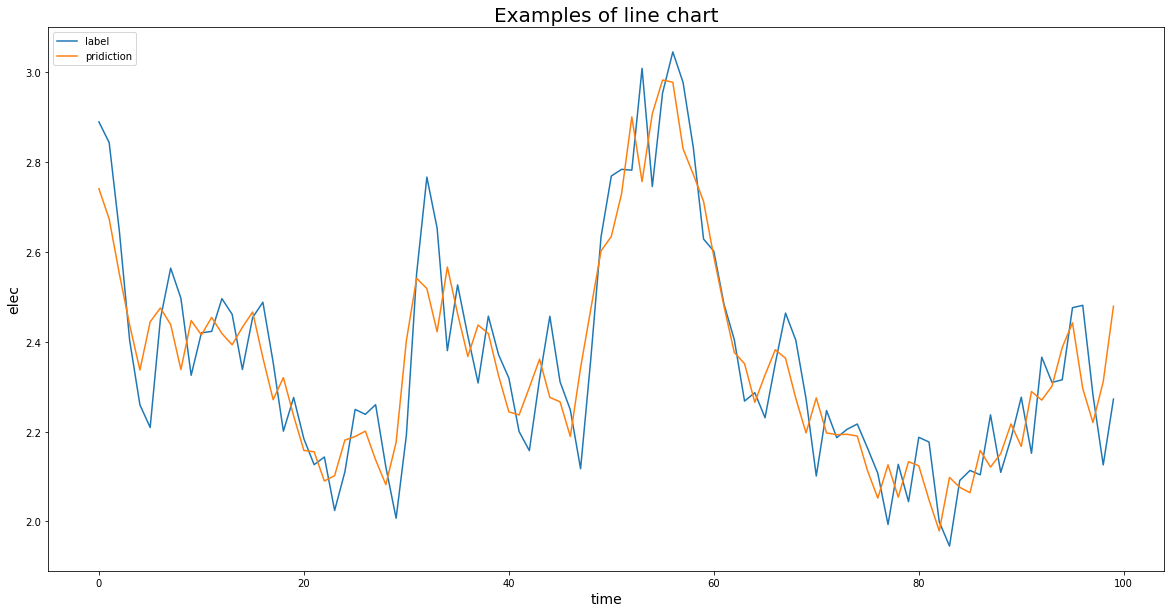

In [14]:
import numpy as np
results_reg = np.array(results_reg)
# results_cla = np.array(results_cla)
labels_reg = np.array(labels_reg)
# labels_cla = np.array(labels_cla)

plt.figure(figsize=(20,10))#设置画布的尺寸
plt.title('Examples of line chart',fontsize=20)#标题，并设定字号大小
plt.xlabel('time',fontsize=14)#设置x轴，并设定字号大小
plt.ylabel('elec',fontsize=14)#设置y轴，并设定字号大小


plot_range = [400,500]
plot_len = plot_range[1] - plot_range[0]

print(len(results_reg))
print(len(labels_reg))

plt.plot(list(range(plot_len)), results_reg[plot_range[0]:plot_range[1]], label='label')
plt.plot(list(range(plot_len)), labels_reg[plot_range[0]:plot_range[1]], label='pridiction')
plt.legend(loc='upper left')
plt.show()


In [23]:
x = []
x.append([])
x.append([])
x.append([]) 
x.append([])

In [24]:
len(x)

4

In [25]:
x

[[], [], [], []]